# Image Prep

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_folder_path = r"G:\My Drive\trainingImages-lane\original"
os.listdir(image_folder_path)

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 'backup-unedited-masks.zip',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 'backup-first-5-masks.zip']

In [10]:
image_file_name = "1.jpg"
mask_file_name = "1.png"

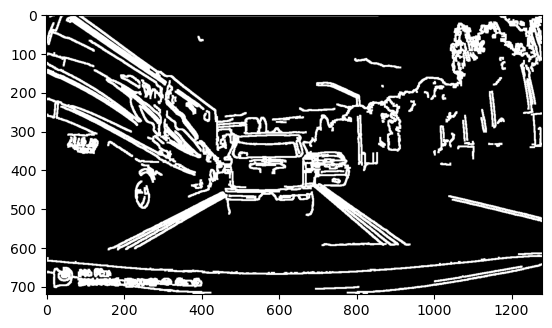

In [42]:
image = cv2.imread(os.path.join(image_folder_path, image_file_name))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),cv2.BORDER_DEFAULT)
low_threshold = 35
high_threshold = 65
edges = cv2.Canny(blur, low_threshold, high_threshold)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(dilation, cmap='gray')

In [43]:
#cv2.imwrite(os.path.join(reg_image_folder_path, mask_file_name), dilation)

## After saving the rought mask to disk, I edit the mask by hand using an image editor.

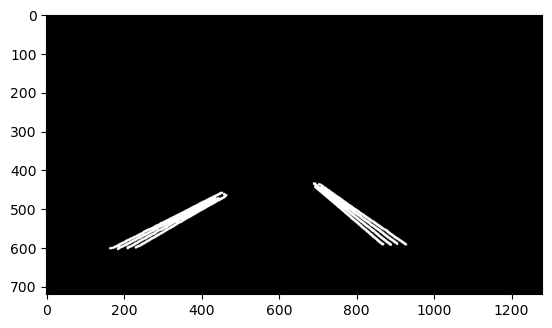

In [48]:
mask_from_file = cv2.imread(os.path.join(image_folder_path, mask_file_name), 0)
plt.imshow(mask_from_file, cmap='gray')

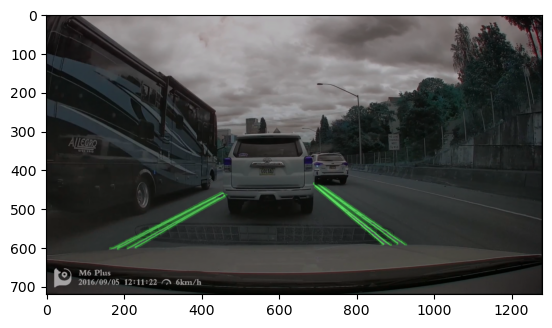

In [47]:
color_mask = np.zeros_like(image)
color_mask[mask_from_file == 255] = (0, 255, 0)
masked_color = cv2.bitwise_and(image, color_mask)
result = cv2.addWeighted(image, 0.7, masked_color, 0.9, 0)
plt.imshow(result)

# Training

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [15]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.Grayscale(),
    transforms.ToTensor()
    #transforms.Normalize([0.5], [0.5]) # I wasn't sure what to put here, this was an example I found...
])

In [16]:
training_folder = r"C:\Users\joeys\source\lane-detection\data_road_modified\data_road\training\prepped_train_data"

In [17]:
# Create the custom dataset class
class LaneDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.masks = []

        for image_name in os.listdir(root_dir):
            if 'mask' in image_name:
                self.masks.append(image_name)
            else:
                self.images.append(image_name)
        print("Length of images list:", len(self.images))
        print("Length of masks list:", len(self.masks))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(image_path)

        mask_path = os.path.join(self.root_dir, self.masks[idx])
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        image = image.to(device)
        maks = mask.to(device)
        return (image, mask)

In [18]:
# Load the data
dataset = LaneDataset(root_dir=training_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

Length of images list: 289
Length of masks list: 289


In [19]:
# Verify input shape
for i, (inputs, labels) in enumerate(dataloader):
   print("input shape:", inputs.shape)
   print("label shape:", labels.shape)
   if i == 10:  # break after first iteration
       break

input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])
input shape: torch.Size([16, 1, 192, 192])
label shape: torch.Size([16, 1, 192, 192])


In [20]:
class SimpleSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters=32):
        super(SimpleSegmentationModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters*4)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_filters*8)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(num_filters*8, out_channels, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        
        return x

In [21]:
model =SimpleSegmentationModel().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
#for i, data in enumerate(dataloader, 0):
 #   inputs, masks = data
  #  print(inputs)
   # print(masks)

In [23]:
for epoch in range(50):
    running_loss = 0.0
    for data, mask in dataloader:
        #inputs, masks = data
        data = data.to(device)
        masks = mask.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        masks = masks.unsqueeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))

print('Finished Training')

# Save the model
torch.save(model.state_dict(), 'lane_detection_model.pth')

C:\Users\joeys\anaconda3\envs\pytorch-lanedetection\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16, 1, 1, 192, 192])) that is different to the input size (torch.Size([16, 1, 192, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\joeys\anaconda3\envs\pytorch-lanedetection\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 1, 192, 192])) that is different to the input size (torch.Size([1, 1, 192, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 loss: 0.266
Epoch 2 loss: 0.124
Epoch 3 loss: 0.120
Epoch 4 loss: 0.118
Epoch 5 loss: 0.115
Epoch 6 loss: 0.113
Epoch 7 loss: 0.113
Epoch 8 loss: 0.111
Epoch 9 loss: 0.111
Epoch 10 loss: 0.108
Epoch 11 loss: 0.108
Epoch 12 loss: 0.108
Epoch 13 loss: 0.107
Epoch 14 loss: 0.107
Epoch 15 loss: 0.105
Epoch 16 loss: 0.104
Epoch 17 loss: 0.103
Epoch 18 loss: 0.102
Epoch 19 loss: 0.101
Epoch 20 loss: 0.100
Epoch 21 loss: 0.100
Epoch 22 loss: 0.100
Epoch 23 loss: 0.098
Epoch 24 loss: 0.099
Epoch 25 loss: 0.097
Epoch 26 loss: 0.098
Epoch 27 loss: 0.096
Epoch 28 loss: 0.096
Epoch 29 loss: 0.096
Epoch 30 loss: 0.095
Epoch 31 loss: 0.094
Epoch 32 loss: 0.094
Epoch 33 loss: 0.094
Epoch 34 loss: 0.096
Epoch 35 loss: 0.094
Epoch 36 loss: 0.096
Epoch 37 loss: 0.097
Epoch 38 loss: 0.092
Epoch 39 loss: 0.091
Epoch 40 loss: 0.090
Epoch 41 loss: 0.090
Epoch 42 loss: 0.090
Epoch 43 loss: 0.090
Epoch 44 loss: 0.090
Epoch 45 loss: 0.088
Epoch 46 loss: 0.088
Epoch 47 loss: 0.087
Epoch 48 loss: 0.087
E

# Prediction

In [24]:
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from PIL import Image
from torchvision.transforms import ToPILImage, ToTensor

In [25]:
model_path = r"C:\Users\joeys\source\lane-detection\lane_detection_model.pth"
image_path = r"C:\Users\joeys\source\lane-detection\data_road_modified\data_road\training\prepped_train_data\um_000000.png"

In [32]:
def predict(model, image):
    # Apply the same data transformations to the image that were used during training
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
    ])
    
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    # Pass the image through the model to get the predictions
    with torch.no_grad():
        logits = model(image)

    # Apply a sigmoid activation function to the predictions to get a mask
    mask = torch.sigmoid(logits)
    mask = mask.cpu()

    return mask.squeeze().numpy()

In [33]:
# This is the model used to train
class SimpleSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters=32):
        super(SimpleSegmentationModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters*4)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_filters*8)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(num_filters*8, out_channels, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        
        return x

In [34]:
# Load the saved model
model = SimpleSegmentationModel()
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleSegmentationModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [35]:
# Read an image from file
image = Image.open(image_path)
print(image.size)

(1242, 375)


In [36]:
mask = predict(model, image)

torch.Size([1, 32, 256, 256])


In [37]:
mask = (mask * 0.5) + 0.5
mask = mask * 255
print(mask)

[[196.0861  197.97261 196.05595 ... 190.26366 191.41032 190.20535]
 [196.35703 201.66962 199.83336 ... 191.33261 191.28337 190.21552]
 [194.25957 197.43092 197.253   ... 190.72961 191.67093 190.17357]
 ...
 [193.81583 196.36163 199.13934 ... 197.16672 195.02249 194.33723]
 [192.96262 193.35797 194.5274  ... 197.29617 194.36194 193.59421]
 [192.17789 192.6299  192.60909 ... 195.85004 193.20882 193.053  ]]


(375, 1242)
[[196.0861  196.0861  196.0861  ... 190.20535 190.20535 190.20535]
 [196.0861  196.0861  196.0861  ... 190.20535 190.20535 190.20535]
 [196.35703 196.35703 196.35703 ... 190.21552 190.21552 190.21552]
 ...
 [193.81583 193.81583 193.81583 ... 194.33723 194.33723 194.33723]
 [192.96262 192.96262 192.96262 ... 193.59421 193.59421 193.59421]
 [192.17789 192.17789 192.17789 ... 193.053   193.053   193.053  ]]


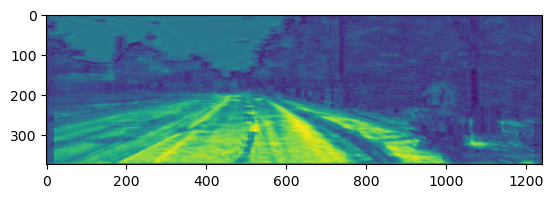

In [38]:
image = cv2.imread(image_path)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
print(mask.shape)
print(mask)
plt.imshow(mask)

True

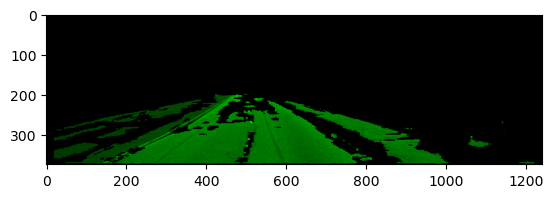

In [48]:
color_mask = np.zeros_like(image)
color_mask[mask >= 203] = (0, 255, 0) # green color
masked_color = cv2.bitwise_and(image, color_mask)
plt.imshow(masked_color)
cv2.imwrite("test.jpg", masked_color)

In [49]:
# Overlay the predicted mask on the original image
print(image.shape)
print(mask.shape)
overlay = cv2.addWeighted(image, 0.9, masked_color, 0.9, 1)
cv2.imwrite("overlay_output.png",overlay)

(375, 1242, 3)
(375, 1242)


True

In [50]:
output_mask_path = r"C:\Users\joeys\source\lane-detection\test.jpg"
output_image_path = r"C:\Users\joeys\source\lane-detection\overlay_output.png"

In [51]:
output_mask = cv2.imread(output_mask_path)
output_image = cv2.imread(output_image_path)

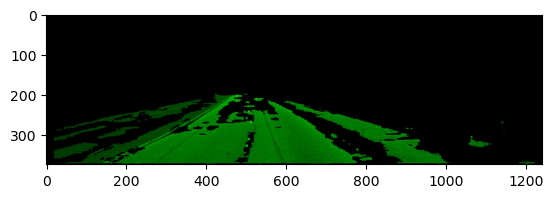

In [52]:
plt.imshow(output_mask)

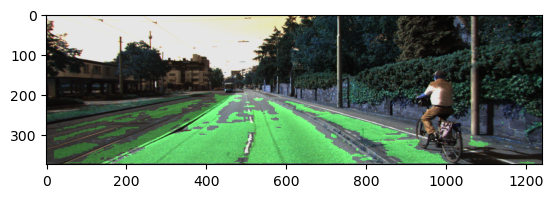

In [53]:
plt.imshow(output_image, cmap='gray')